In [14]:
# Cell 1: Introduction (Markdown)
"""
# Model Evaluation for VAE-GAN

This notebook evaluates the performance of the trained VAE-GAN model by exploring its latent space and performing a qualitative evaluation of the reconstructions. We use PCA and t-SNE to visualize the latent space and compare a few original samples with their reconstructions.
"""


'\n# Model Evaluation for VAE-GAN\n\nThis notebook evaluates the performance of the trained VAE-GAN model by exploring its latent space and performing a qualitative evaluation of the reconstructions. We use PCA and t-SNE to visualize the latent space and compare a few original samples with their reconstructions.\n'

In [19]:
# Cell 2: Load Trained Model and Data

import torch
import os
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Set up the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------------------------------------
# Import the required classes from your training module
# and add them to the safe globals.
# -------------------------------------------------------
try:
    from src.models.optimization.vae_gan import VAEGAN, Encoder, Decoder, Discriminator
    torch.serialization.add_safe_globals([
        ("VAEGAN", VAEGAN),
        ("Encoder", Encoder),
        ("Decoder", Decoder),
        ("Discriminator", Discriminator)
    ])
    print("Safe globals added for VAEGAN, Encoder, Decoder, and Discriminator.")
except Exception as e:
    print("Error adding safe globals:", e)

# ----------------------------
# Load the Trained Model
# ----------------------------
# Since the notebook is in the 'notebooks' directory,
# we need to go up one level to reach the project root.
model_path = os.path.join("..", "src", "models", "trained_model.pt")
model_path = os.path.abspath(model_path)
print("Loading trained model from:", model_path)

try:
    # Force full loading by setting weights_only=False
    trained_model = torch.load(model_path, map_location=device, weights_only=False)
    trained_model.to(device)
    trained_model.eval()
    print("Trained model loaded successfully.")
except Exception as e:
    print("Error loading trained model:", e)

# ----------------------------
# Load the Cleaned Data
# ----------------------------
# The cleaned CSV file is assumed to be located at:
# <project_root>/src/synthetic_data/data/processed/synthetic_logistics_data_cleaned.csv
data_file = os.path.join("..", "src", "synthetic_data", "data", "processed", "synthetic_logistics_data_cleaned.csv")
data_file = os.path.abspath(data_file)
print("Loading data from:", data_file)

try:
    df = pd.read_csv(data_file)
    # Select the features used during training
    features = ['volume', 'cost', 'transit_time', 'co2_emissions', 'cost_per_tonkkm']
    df_model = df[features].dropna()

    # Normalize the features
    scaler = StandardScaler()
    data_array = scaler.fit_transform(df_model.values)

    # Convert to a PyTorch tensor and create a TensorDataset
    data_tensor = torch.tensor(data_array, dtype=torch.float32)
    dataset = TensorDataset(data_tensor)
    print("Data loaded and preprocessed successfully.")
except Exception as e:
    print("Error loading data:", e)


Device: cpu
Safe globals added for VAEGAN, Encoder, Decoder, and Discriminator.
Loading trained model from: /Users/mortezapourjahangiri/PycharmProjects/PythonProject/VAE_GAN_Logistics_Framework/src/models/trained_model.pt
Trained model loaded successfully.
Loading data from: /Users/mortezapourjahangiri/PycharmProjects/PythonProject/VAE_GAN_Logistics_Framework/src/synthetic_data/data/processed/synthetic_logistics_data_cleaned.csv
Data loaded and preprocessed successfully.


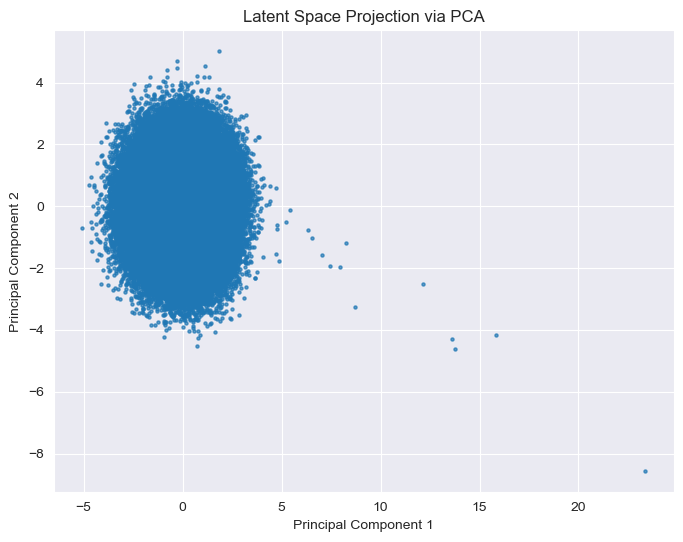

In [20]:
# Cell 3: Latent Space Exploration using PCA

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA

# Ensure the model is in evaluation mode (redundant but safe)
trained_model.eval()

# Create a DataLoader for the dataset with a reasonable batch size.
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Collect all latent vectors from the entire dataset.
all_latents = []
with torch.no_grad():
    for (data_batch,) in loader:
        data_batch = data_batch.to(device)
        # Use the encoder to get the latent parameters.
        mu, logvar = trained_model.encoder(data_batch)
        # Reparameterize to sample latent vectors.
        z = trained_model.reparameterize(mu, logvar)
        all_latents.append(z.cpu().numpy())

# Concatenate all latent vectors into one array.
all_latents = np.concatenate(all_latents, axis=0)  # Shape: (num_samples, latent_dim)

# Use PCA to reduce the latent space to 2 dimensions.
pca = PCA(n_components=2)
latent_2d_pca = pca.fit_transform(all_latents)

# Plot the PCA result.
plt.figure(figsize=(8, 6))
plt.scatter(latent_2d_pca[:, 0], latent_2d_pca[:, 1], s=5, alpha=0.7)
plt.title("Latent Space Projection via PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


In [ ]:
# Cell 4: Latent Space Exploration using t-SNE

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Use t-SNE for a non-linear 2D projection of the latent space.
# Updated to use 'max_iter' instead of 'n_iter' per scikit-learn's newer standards.
tsne = TSNE(n_components=2, perplexity=30, max_iter=300, random_state=42)
latent_2d_tsne = tsne.fit_transform(all_latents)

# Plot the t-SNE result.
plt.figure(figsize=(8, 6))
plt.scatter(latent_2d_tsne[:, 0], latent_2d_tsne[:, 1], s=5, alpha=0.7)
plt.title("Latent Space Projection via t-SNE")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


In [ ]:
# Cell 5: Qualitative Evaluation - Numeric Comparison of Reconstructions

num_examples = 5  # Number of examples to visualize
with torch.no_grad():
    # Get a few sample data points from the training dataset.
    sample_data = data_tensor[:num_examples].to(device)
    # Forward pass through the model.
    recon_data, _, _, _ = trained_model(sample_data)

# Convert tensors to NumPy arrays.
sample_data = sample_data.cpu().numpy()
recon_data = recon_data.cpu().numpy()

print("Qualitative Evaluation:")
for i in range(num_examples):
    print(f"Example {i+1}:")
    print("Original:      ", sample_data[i])
    print("Reconstruction:", recon_data[i])
    print("-" * 50)


In [ ]:
# Cell 6: Qualitative Evaluation - Visual Comparison with Bar Charts

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(2, num_examples)

for i in range(num_examples):
    ax0 = fig.add_subplot(gs[0, i])
    ax0.bar(range(sample_data.shape[1]), sample_data[i])
    ax0.set_ylim([np.min(sample_data)-0.5, np.max(sample_data)+0.5])
    ax0.set_title(f"Original {i+1}")

    ax1 = fig.add_subplot(gs[1, i])
    ax1.bar(range(recon_data.shape[1]), recon_data[i])
    ax1.set_ylim([np.min(sample_data)-0.5, np.max(sample_data)+0.5])
    ax1.set_title(f"Reconstruction {i+1}")

plt.suptitle("Comparison: Original vs Reconstructed Data")
plt.show()


In [ ]:
# Cell 7: Conclusions (Markdown)
"""
## Conclusions

- **Latent Space Exploration:**
  The PCA and t-SNE plots show the organization of the latent space. You can inspect how well-separated the embeddings are, which may reflect the model's ability to capture meaningful data structure.

- **Qualitative Evaluation:**
  The numerical and bar chart comparisons of a few samples indicate how closely the model's reconstructions match the original data. Small differences suggest that the model is effectively learning the underlying features.

These observations provide insight into the quality of the learned embeddings and the reconstruction performance. With this evaluation complete, the next step is to integrate these model outputs into the simulation engine for end-to-end performance assessment.
"""
